# Wasserstein Distances

Import Libraries

In [80]:
import os
import random
import glob
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.stats as stats

sys.path.append(os.path.abspath('./../../sdo_augmentation/'))
from augmentation import Augmentations

# Calculating the 1D Power Spectrum

Define 1D Power Spectrum Method

In [81]:
# Calculates 1d Power Spectrum
def power_spectrum_1d(image):

    #Get pixel count
    pixel_count = image.shape[0]

    # Convert into fourier transform
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)

    #Calculate 1D power spectrum
    k_frequencies = np.fft.fftfreq(pixel_count) * pixel_count
    k_frequencies2D = np.meshgrid(k_frequencies, k_frequencies)
    k_norm = np.sqrt(k_frequencies2D[0] ** 2 + k_frequencies2D[1] ** 2)
    k_bins = np.arange(0.5, pixel_count // 2 + 1, 1.)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    a_bins, _, _ = stats.binned_statistic(k_norm.flatten(),
                                        (fourier_amplitudes ** 2).flatten(),
                                        statistic = "mean", bins = k_bins)
    a_bins *= np.pi * (k_bins[1:] ** 2 - k_bins[:-1] ** 2)
    return a_bins

Get 1D Power Spectrum and Wasserstein Distance of Original Image

In [82]:
# Open image
image_path = './../../AIA171_Miniset_BW/20130217_000001_aia_171_4k/tiles/20130217_000001_aia_171_4k_tile_1024_3072.jpg'
image = np.array(Image.open(image_path).convert('L'))
image = image.astype(float) / 255

original_power_spectrum_1d = power_spectrum_1d(image)

# Investigating with Augmentations

### Rotation

In [83]:
# Create set of degrees to rotate
set_degrees = np.arange(5, 50, 5)
rotated_images = []
power_spectrums = []
wasserstein_distances = []

for i in set_degrees:
    
    # Create rotated image
    augmentation = Augmentations(image, {'rotate': i})
    rotated_image, _ = augmentation.perform_augmentations(fill_void = 'Nearest')
    rotated_images.append(rotated_image)

    # Get 1D power spectrum
    power_spectrums.append(power_spectrum_1d(rotated_image))

    # Calculate Wasserstein Distance of original image vs rotated iamge
    wasserstein_distance = stats.wasserstein_distance(original_power_spectrum_1d, power_spectrums[-1])
    wasserstein_distances.append(wasserstein_distance)
    print('Degree:', i, 'Wasserstein Distance:', wasserstein_distance)

Degree: 5 Wasserstein Distance: 401.43595902182574
Degree: 10 Wasserstein Distance: 650.6555066550484
Degree: 15 Wasserstein Distance: 1013.1218577325553
Degree: 20 Wasserstein Distance: 1137.6342363470571
Degree: 25 Wasserstein Distance: 1275.7059189317083
Degree: 30 Wasserstein Distance: 1586.4448779904944
Degree: 35 Wasserstein Distance: 1816.7051581467972
Degree: 40 Wasserstein Distance: 1754.4923491491168
Degree: 45 Wasserstein Distance: 1589.957596512647


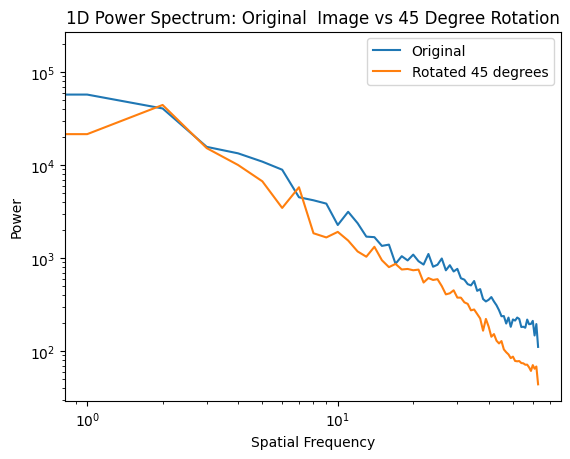

In [84]:
# Plot original image vs rotated one
plt.title('1D Power Spectrum: Original  Image vs ' + str(set_degrees[-1]) + ' Degree Rotation')
plt.loglog(original_power_spectrum_1d)
plt.loglog(power_spectrums[-1])
plt.legend(['Original', 'Rotated ' + str(set_degrees[-1]) + ' degrees'])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()

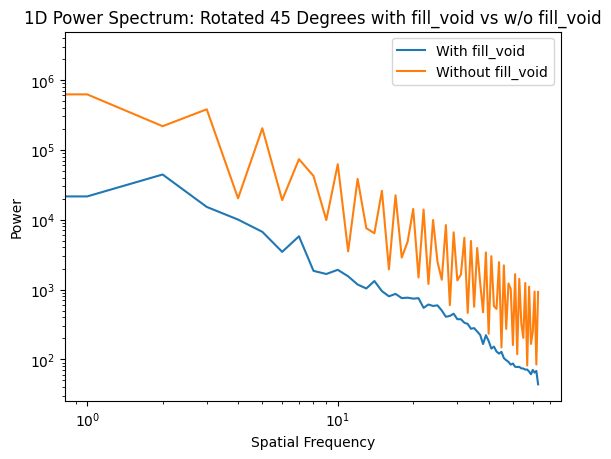

In [85]:
# Compares last rotation with and without fill_void
augmentation = Augmentations(image, {'rotate': set_degrees[-1]})
rotated_without_fill_void, _ = augmentation.perform_augmentations()
plt.title('1D Power Spectrum: Rotated ' + str(set_degrees[-1]) + ' Degrees with fill_void vs w/o fill_void')
plt.loglog(power_spectrums[-1])
plt.loglog(power_spectrum_1d(rotated_without_fill_void))
plt.legend(['With fill_void', 'Without fill_void'])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()

### Brightness

In [86]:
# Create set of values to brighten
set_brightness = np.round(np.arange(.5, 1.6, .1), 2)
brightened_images = []
power_spectrums = []
wasserstein_distances = []

for i in set_brightness:
    
    # Create brightened image
    augmentation = Augmentations(image, {'brighten': i})
    brightened_image, _ = augmentation.perform_augmentations(fill_void = 'Nearest')
    brightened_images.append(brightened_image)

    # Get 1D power spectrum
    power_spectrums.append(power_spectrum_1d(brightened_image))

    # Calculate Wasserstein Distance of original image vs brightened iamge
    wasserstein_distance = stats.wasserstein_distance(original_power_spectrum_1d, power_spectrums[-1])
    wasserstein_distances.append(wasserstein_distance)
    print('Brightness:', i, 'Wasserstein Distance:', wasserstein_distance)


Brightness: 0.5 Wasserstein Distance: 2214.4196959621304
Brightness: 0.6 Wasserstein Distance: 1487.4737110139044
Brightness: 0.7 Wasserstein Distance: 902.1007185071273
Brightness: 0.8 Wasserstein Distance: 464.03451650158695
Brightness: 0.9 Wasserstein Distance: 167.51770424385307
Brightness: 1.0 Wasserstein Distance: 0.0
Brightness: 1.1 Wasserstein Distance: 54.604645338840676
Brightness: 1.2 Wasserstein Distance: 52.574857320322074
Brightness: 1.3 Wasserstein Distance: 116.76279879074961
Brightness: 1.4 Wasserstein Distance: 286.3169900622571
Brightness: 1.5 Wasserstein Distance: 514.364790908048


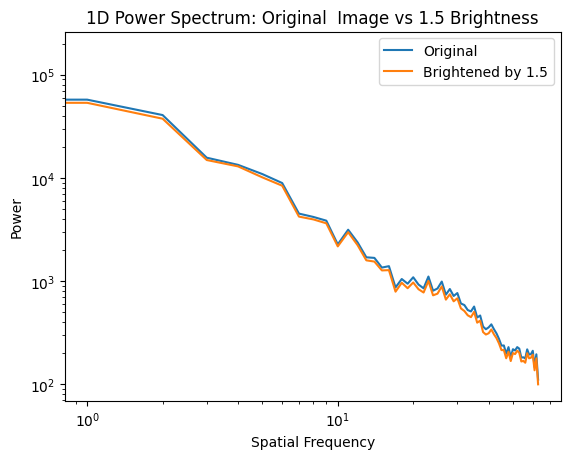

In [87]:
# Plot original image vs brightened one
plt.title('1D Power Spectrum: Original  Image vs ' + str(set_brightness[-1]) + ' Brightness')
plt.loglog(original_power_spectrum_1d)
plt.loglog(power_spectrums[-1])
plt.legend(['Original', 'Brightened by ' + str(set_brightness[-1])])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()

### Translation

In [88]:
# Create set of degrees to translate
set_translation = np.arange(-10, 11, 2)
translated_images = []
power_spectrums = []
wasserstein_distances = []

# Calculate along x-axis
for i in set_translation:
    
    # Create tranalated image
    augmentation = Augmentations(image, {'translate': (i, 0)})
    translated_image, _ = augmentation.perform_augmentations(fill_void = 'Nearest')
    translated_images.append(translated_image)

    # Get 1D power spectrum
    power_spectrums.append(power_spectrum_1d(translated_image))

    # Calculate Wasserstein Distance of original image vs tranalated iamge
    wasserstein_distance = stats.wasserstein_distance(original_power_spectrum_1d, power_spectrums[-1])
    wasserstein_distances.append(wasserstein_distance)
    print('Translation across x-asis:', i, 'Wasserstein Distance:', wasserstein_distance)

print('\n')
translated_images = []
power_spectrums = []
wasserstein_distances = []

# Calculate along y-axis
for i in set_translation:
    
    # Create rotated image
    augmentation = Augmentations(image, {'translate': (0, i)})
    translated_image, _ = augmentation.perform_augmentations(fill_void = 'Nearest')
    translated_images.append(translated_image)

    # Get 1D power spectrum
    power_spectrums.append(power_spectrum_1d(translated_image))

    # Calculate Wasserstein Distance of original image vs rotated iamge
    wasserstein_distance = stats.wasserstein_distance(original_power_spectrum_1d, power_spectrums[-1])
    wasserstein_distances.append(wasserstein_distance)
    print('Translation across y-asis:', i, 'Wasserstein Distance:', wasserstein_distance)

Translation across x-asis: -10 Wasserstein Distance: 1345.3003963297424
Translation across x-asis: -8 Wasserstein Distance: 1127.2111211491
Translation across x-asis: -6 Wasserstein Distance: 897.6849306664321
Translation across x-asis: -4 Wasserstein Distance: 618.4952928480652
Translation across x-asis: -2 Wasserstein Distance: 324.0053603724312
Translation across x-asis: 0 Wasserstein Distance: 0.0
Translation across x-asis: 2 Wasserstein Distance: 366.0179588270185
Translation across x-asis: 4 Wasserstein Distance: 723.7230740553501
Translation across x-asis: 6 Wasserstein Distance: 1041.6071187918772
Translation across x-asis: 8 Wasserstein Distance: 1337.7795218792114
Translation across x-asis: 10 Wasserstein Distance: 1600.3946938237532


Translation across y-asis: -10 Wasserstein Distance: 1248.7828026609582
Translation across y-asis: -8 Wasserstein Distance: 1041.4422354462658
Translation across y-asis: -6 Wasserstein Distance: 821.7909071081814
Translation across y-asis: -4 W

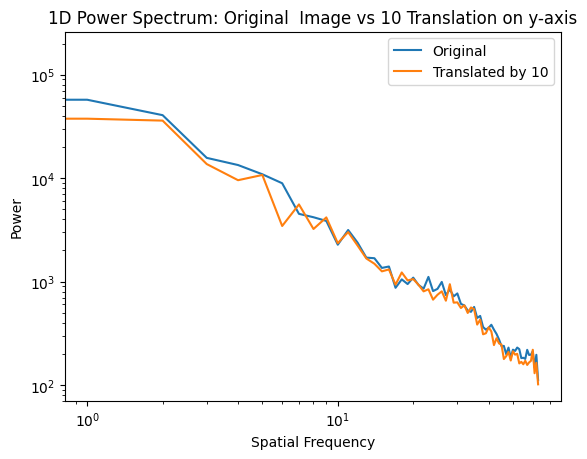

In [89]:
# Plot original image vs translated one
plt.title('1D Power Spectrum: Original  Image vs ' + str(set_translation[-1]) + ' Translation on y-axis')
plt.loglog(original_power_spectrum_1d)
plt.loglog(power_spectrums[-1])
plt.legend(['Original', 'Translated by ' + str(set_translation[-1])])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()

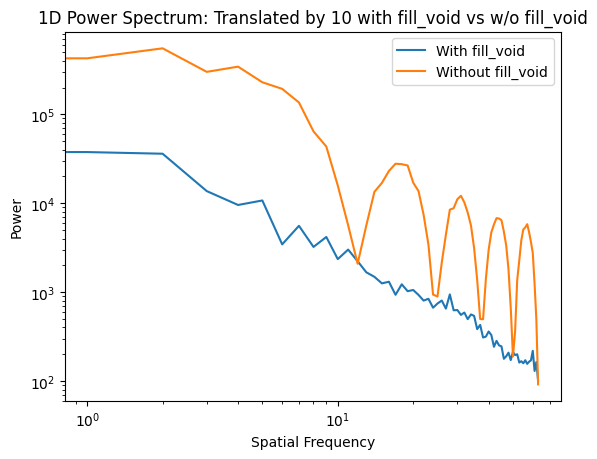

In [90]:
# Compares last translation with and without fill_void
augmentation = Augmentations(image, {'translate': (0, set_translation[-1])})
translated_without_fill_void, _ = augmentation.perform_augmentations()
plt.title('1D Power Spectrum: Translated by ' + str(set_translation[-1]) + ' with fill_void vs w/o fill_void')
plt.loglog(power_spectrums[-1])
plt.loglog(power_spectrum_1d(translated_without_fill_void))
plt.legend(['With fill_void', 'Without fill_void'])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()

### Zoom

In [92]:
# Create set of degrees to zoom
set_zoom = np.round(np.arange(.8, 1.21, .04), 3)
zoomed_images = []
power_spectrums = []
wasserstein_distances = []

for i in set_zoom:
    
    # Create zoomed image
    augmentation = Augmentations(image, {'zoom': i})
    zoomed_image, _ = augmentation.perform_augmentations(fill_void = 'Nearest')
    zoomed_images.append(zoomed_image)

    # Get 1D power spectrum
    power_spectrums.append(power_spectrum_1d(zoomed_image))

    # Calculate Wasserstein Distance of original image vs rotated iamge
    wasserstein_distance = stats.wasserstein_distance(original_power_spectrum_1d, power_spectrums[-1])
    wasserstein_distances.append(wasserstein_distance)
    print('Zoom:', i, 'Wasserstein Distance:', wasserstein_distance)

Zoom: 0.8 Wasserstein Distance: 2973.031747524714
Zoom: 0.84 Wasserstein Distance: 2178.6634554619736
Zoom: 0.88 Wasserstein Distance: 1542.1983787382599
Zoom: 0.92 Wasserstein Distance: 979.6035623605629
Zoom: 0.96 Wasserstein Distance: 526.9160531697704
Zoom: 1.0 Wasserstein Distance: 0.0
Zoom: 1.04 Wasserstein Distance: 476.2330243291931
Zoom: 1.08 Wasserstein Distance: 814.9376783749407
Zoom: 1.12 Wasserstein Distance: 1185.4753069995145
Zoom: 1.16 Wasserstein Distance: 1471.815764163041
Zoom: 1.2 Wasserstein Distance: 1726.4186474517408


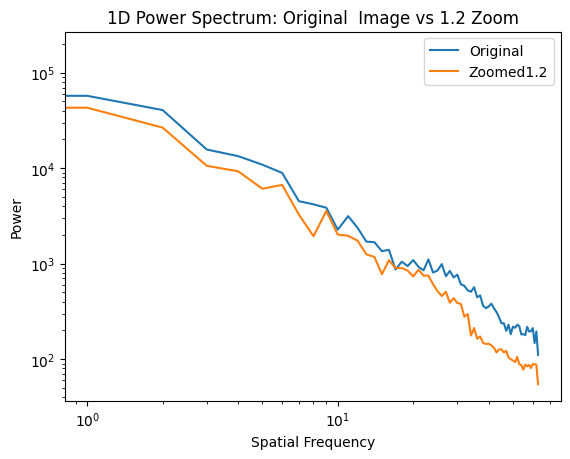

In [93]:
# Plot original image vs zoomed one
plt.title('1D Power Spectrum: Original  Image vs ' + str(set_zoom[-1]) + ' Zoom')
plt.loglog(original_power_spectrum_1d)
plt.loglog(power_spectrums[-1])
plt.legend(['Original', 'Zoomed' + str(set_zoom[-1])])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()

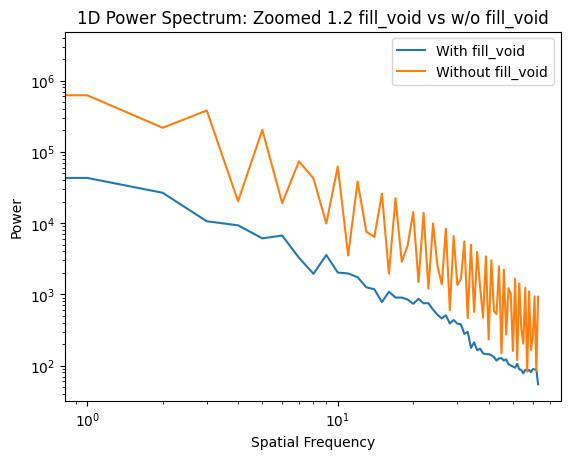

In [94]:
# Compares last zoom with and without fill_void
augmentation = Augmentations(image, {'zoom': set_zoom[-1]})
zoomed_without_fill_void, _ = augmentation.perform_augmentations()
plt.title('1D Power Spectrum: Zoomed ' + str(set_zoom[-1]) + ' fill_void vs w/o fill_void')
plt.loglog(power_spectrums[-1])
plt.loglog(power_spectrum_1d(rotated_without_fill_void))
plt.legend(['With fill_void', 'Without fill_void'])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()

### V-Flip and H-Flip

In [ ]:
# Calculate for v-flip
augmentation = Augmentations(image, {'v_flip': True})
v_flip_image, _ = augmentation.perform_augmentations(fill_void = 'Nearest')
v_flip_power_spectrum = power_spectrum_1d(v_flip_image)
wasserstein_distance = stats.wasserstein_distance(original_power_spectrum_1d, v_flip_power_spectrum)
print('V-Flip Wasserstein Distance:', wasserstein_distance)

# Calculate for h-flip
augmentation = Augmentations(image, {'h_flip': True})
h_flip_image, _ = augmentation.perform_augmentations(fill_void = 'Nearest')
h_flip_power_spectrum = power_spectrum_1d(h_flip_image)
wasserstein_distance = stats.wasserstein_distance(original_power_spectrum_1d, h_flip_power_spectrum)
print('H-Flip Wasserstein Distance:', wasserstein_distance)

V-Flip Wasserstein Distance: 9.64117674584486e-13
H-Flip Wasserstein Distance: 8.024692021990631e-13


### Blur

In [98]:
# Create set of degrees to zoom
set_blur = np.arange(1, 11, 1)
blurred_images = []
power_spectrums = []
wasserstein_distances = []

for i in set_blur:

    # Create zoomed image
    augmentation = Augmentations(image, {'blur': (i, i)})
    blurred_image, _ = augmentation.perform_augmentations(fill_void = 'Nearest')
    blurred_images.append(blurred_image)

    # Get 1D power spectrum
    power_spectrums.append(power_spectrum_1d(blurred_image))

    # Calculate Wasserstein Distance of original image vs blurred iamge
    wasserstein_distance = stats.wasserstein_distance(original_power_spectrum_1d, power_spectrums[-1])
    wasserstein_distances.append(wasserstein_distance)
    print('Blur:', i, 'Wasserstein Distance:', wasserstein_distance)

Blur: 1 Wasserstein Distance: 0.0
Blur: 2 Wasserstein Distance: 154.85922664709594
Blur: 3 Wasserstein Distance: 234.2246278418964
Blur: 4 Wasserstein Distance: 330.1211840487965
Blur: 5 Wasserstein Distance: 392.55188777791227
Blur: 6 Wasserstein Distance: 458.55148340420067
Blur: 7 Wasserstein Distance: 526.3919584199436
Blur: 8 Wasserstein Distance: 587.8345093556146
Blur: 9 Wasserstein Distance: 653.833617061527
Blur: 10 Wasserstein Distance: 712.5720163729878


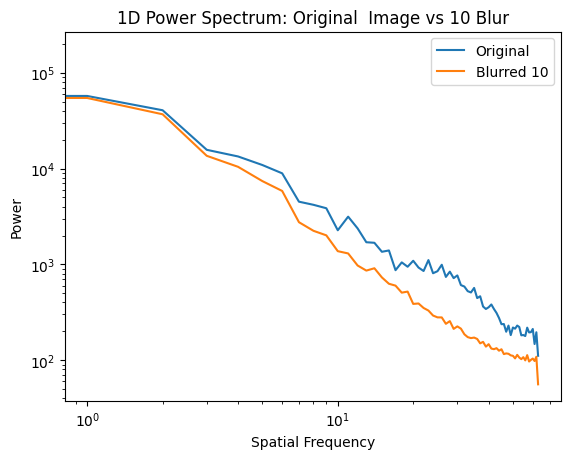

In [ ]:
# Plot original image vs rotated one
plt.title('1D Power Spectrum: Original  Image vs ' + str(set_blur[-1]) + ' Blur')
plt.loglog(original_power_spectrum_1d)
plt.loglog(power_spectrums[-1])
plt.legend(['Original', 'Blurred ' + str(set_blur[-1])])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()

In [ ]:
# Compares last blurred image with and without fill_void
augmentation = Augmentations(image, {'blur': (set_blur[-1], set_blur[-1])})
blurred_without_fill_void, _ = augmentation.perform_augmentations()
plt.title('1D Power Spectrum: Zoomed ' + str(set_zoom[-1]) + ' fill_void vs w/o fill_void')
plt.loglog(power_spectrums[-1])
plt.loglog(power_spectrum_1d(rotated_without_fill_void))
plt.legend(['With fill_void', 'Without fill_void'])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()